# "Training a MNIST classifier"

- comments: true
- tags: SGD, fastai, pytorch, sigmoid, mnist

###### The work below is based on the chapter 4 of [Deep learning for Coders with fastai and PyTorch](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) and github repo dedicated to that chapter by [asiedubrempong](https://gist.github.com/asiedubrempong).

Will be using here [fastai](https://www.fast.ai/about/) that is basically a high-level API for deep learning over PyTorch and easier to use.

I encourage you to use Google Colab for this project.

Below we are importing necessary libraries. I for some reason this cell gives you a mistake - uncomment the first line, restart your runtime and run it again.

In [1]:
# !pip install -U fastai

import fastai
from fastai.vision.all import *

Checking if fastai installed correctly.

In [2]:
fastai.__version__

'2.2.5'

Fastai comes with a basic and most popular datasets to work with. Let's use that in our advantage and import MNIST dataset to our path.

In [3]:
path = untar_data(URLs.MNIST)

Let's see how MNIST dataset is structured.
It is already broke down for us into training and testing dataset. 
Good.

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

Inside training dataset we can see folders with numbers from 0 to 10.

In [5]:
(path/'training').ls().sorted()

(#10) [Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/9')]

Let's look even closer into data and try to print out one digit.

In [6]:
fours = (path/'training/4').ls()

In [7]:
img4_path = fours[1] #taking 1st index of data
img4 = Image.open(img4_path) #using PIL to open image file
img4

To display how computer sees this image we need to use arrays or tensors. 
After we converted image to tensor we pack it into dataframe using Pandas library. If you are not using Gogle Colab, you will have to import it.

`import pandas as pd`

In [8]:
img4_t = tensor(img4) 
df = pd.DataFrame(img4_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,68,201,227,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,190,252,252,182,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,51,242,252,252,0,0,0,6,153,233,111,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,161,252,252,0,0,0,64,252,253,168,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,127,252,252,0,0,0,64,252,253,168,0,0,0,0,0,0,0


Now we are collecting the paths to image folders into a dictionary.

In [9]:
path_len = len((path/'training').ls())
paths = {i: [fn for fn in (path/f'training/{i}').ls()] for i in range(path_len)}
paths[0][:5]

[Path('/root/.fastai/data/mnist_png/training/0/22013.png'),
 Path('/root/.fastai/data/mnist_png/training/0/59934.png'),
 Path('/root/.fastai/data/mnist_png/training/0/55484.png'),
 Path('/root/.fastai/data/mnist_png/training/0/37043.png'),
 Path('/root/.fastai/data/mnist_png/training/0/9820.png')]

Converting images to tensors.

In [10]:
img_tensors = {key: [tensor(Image.open(path)) for path in paths] for (key, paths) in paths.items()}

Stacking tensors one on each other to get mean representation of what machine thinks is "a mean number", so we could later compair single digit to the mean of that digit. 

In [11]:
stacked_tensors = {key: torch.stack(imgs).float() / 255 
                   for (key, imgs) in img_tensors.items()}

In [12]:
for _ , values in stacked_tensors.items():
  print(values.shape)

torch.Size([5923, 28, 28])
torch.Size([6742, 28, 28])
torch.Size([5958, 28, 28])
torch.Size([6131, 28, 28])
torch.Size([5842, 28, 28])
torch.Size([5421, 28, 28])
torch.Size([5918, 28, 28])
torch.Size([6265, 28, 28])
torch.Size([5851, 28, 28])
torch.Size([5949, 28, 28])


In [13]:
mean_tensors = {key: imgs.mean(0) for (key, imgs) in stacked_tensors.items()}

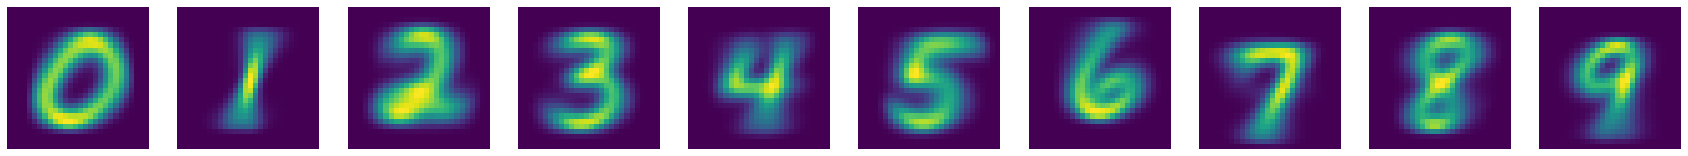

In [14]:
show_images(mean_tensors.values())

Let's grab a single digit from stacked tensors and try to calculate the distance between it and other digits. For that we are writing function 'distance' and 'is_3'

Function 'distance' calculates [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error). I encourage you to read more on the topic of [MAE & RMSE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d).

Then we compare our number a_3 to any other mean digit and produce the result if it is the number we are looking for.

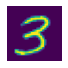

In [15]:
a_3 = stacked_tensors[3][2]
show_image(a_3)

In [16]:
def distance(a, b): return (a - b).abs().mean((-1, -2))
distance(a_3, mean_tensors[3])

tensor(0.1192)

In [17]:
def is_3(x): return distance(x,mean_tensors[3]) < distance(x,mean_tensors[4])

In [18]:
is_3(a_3)

tensor(True)

Now we need to prepare data. We are splitting dataset into train/test, labeling targets and putting datasets into [DataLoader](https://docs.fast.ai/data.load.html). 

In [19]:
def create_labels(rows, cols, index):
    labels = torch.zeros((rows, cols))
    labels[:, index] = 1
    return labels

In [20]:
test_paths = {i: [p for p in (path/f'testing/{i}').ls()] for i in range(path_len)}
test_stacked_tensors = {key: torch.stack([tensor(Image.open(path)) for path in paths]).float()/255 
                         for (key, paths) in test_paths.items()}

test_stacked_labels = {key: create_labels(tensors.shape[0], len(test_stacked_tensors), key)
                        for key, tensors in test_stacked_tensors.items()}

test_x = torch.cat([o for o in test_stacked_tensors.values()]).view(-1, 28*28)
test_y = torch.cat([o for o in test_stacked_labels.values()])

In [21]:
train_x = torch.cat([o for o in stacked_tensors.values()]).view(-1, 28*28)
train_y = torch.cat([o for o in test_stacked_labels.values()])

In [22]:
train_dataset = list(zip(train_x, train_y))
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = list(zip(test_x, test_y))
test_dl = DataLoader(test_dataset, batch_size=64)

Defining our loss function that measures the distance between predictions and targets. We are using here the sigmoid function as it always outputs a number between 0 and 1, and we don't want it to be below 0.

In [23]:
def mnist_loss(xb, yb):
    xb = xb.sigmoid()
    return torch.where(yb==1, 1-xb, xb).mean()

Time to define basic steps for our model.

For more details please visit [chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)
of the 'Deep learning for Coders with fastai and PyTorch' book.

In [24]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [25]:
weights = init_params((28*28,10))
bias = init_params(1)

In [26]:
def linear1(xb): return xb@weights + bias

In [27]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [28]:
def train_epoch(model, lr, params):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [29]:
def cal_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [30]:
def validate_epoch(model):
    accs = [cal_accuracy(model(xb), yb) for xb,yb in test_dl]
    return round(torch.stack(accs).mean().item(), 4)

Setting learning rate and parameters.

In [31]:
lr = 0.1
params = weights, bias

Let's see how it goes!

In [32]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6658 0.7118 0.7424 0.7635 0.7809 0.7963 0.809 0.8233 0.8405 0.8574 0.8648 0.8689 0.8718 0.8738 0.8757 0.8771 0.8783 0.8794 0.8802 0.8811 

So we reached 88% accuracy using only math and some basic functions :)

But we could have done everything much simpler like that using inner tools of fastai and PyTorch:

In [33]:
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')

learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.069037,0.035452,0.988200,14:47
